In [54]:
import gymnasium
import flappy_bird_gymnasium
import pickle
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
import gc
import numpy as np
import pygame
import itertools
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Categorical
from collections import deque
from enum import IntEnum
from torchvision.transforms import Compose, ToTensor, Resize, Grayscale
from flappy_bird_gymnasium.envs.flappy_bird_env import FlappyBirdEnv
from flappy_bird_gymnasium.envs.flappy_bird_env import Actions
from flappy_bird_gymnasium.envs import utils
from flappy_bird_gymnasium.envs.lidar import LIDAR
from flappy_bird_gymnasium.envs.constants import (
    BACKGROUND_WIDTH,
    BASE_WIDTH,
    FILL_BACKGROUND_COLOR,
    LIDAR_MAX_DISTANCE,
    PIPE_HEIGHT,
    PIPE_VEL_X,
    PIPE_WIDTH,
    PLAYER_ACC_Y,
    PLAYER_FLAP_ACC,
    PLAYER_HEIGHT,
    PLAYER_MAX_VEL_Y,
    PLAYER_PRIVATE_ZONE,
    PLAYER_ROT_THR,
    PLAYER_VEL_ROT,
    PLAYER_WIDTH,
)
from typing import Dict, Optional, Tuple, Union

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.cm as cm
from matplotlib.font_manager import FontProperties



def new_render(self):
    """Renders the next frame."""
    if self.render_mode == "rgb_array":
        self._draw_surface(show_score=False, show_rays=False)
        # Flip the image to retrieve a correct aspect
        return np.transpose(pygame.surfarray.array3d(self._surface), axes=(1, 0, 2))
    else:
        self._draw_surface(show_score=True, show_rays=False)
        if self._display is None:
            self._make_display()

        self._update_display()
        self._fps_clock.tick(self.metadata["render_fps"])

def new_step(
    self,
    action: Union[Actions, int],
) -> Tuple[np.ndarray, float, bool, Dict]:
    """Given an action, updates the game state.

    Args:
        action (Union[FlappyBirdLogic.Actions, int]): The action taken by
            the agent. Zero (0) means "do nothing" and one (1) means "flap".

    Returns:
        A tuple containing, respectively:

            * an observation (horizontal distance to the next pipe
                difference between the player's y position and the next hole's
                y position)
            * a reward (alive = +0.1, pipe = +1.0, dead = -1.0)
            * a status report (`True` if the game is over and `False`
                otherwise)
            * an info dictionary
    """
    """Given an action taken by the player, updates the game's state.

    Args:
        action (Union[FlappyBirdLogic.Actions, int]): The action taken by
            the player.

    Returns:
        `True` if the player is alive and `False` otherwise.
    """
    terminal = False
    reward = None

    self._sound_cache = None
    if action == Actions.FLAP:
        if self._player_y > -2 * PLAYER_HEIGHT:
            self._player_vel_y = PLAYER_FLAP_ACC
            self._player_flapped = True
            self._sound_cache = "wing"

    # check for score
    player_mid_pos = self._player_x + PLAYER_WIDTH / 2
    for pipe in self._upper_pipes:
        pipe_mid_pos = pipe["x"] + PIPE_WIDTH / 2
        if pipe_mid_pos <= player_mid_pos < pipe_mid_pos + 4:
            self._score += 1
            reward = 1.0  # reward for passed pipe
            self._sound_cache = "point"

    # player_index base_x change
    if (self._loop_iter + 1) % 3 == 0:
        self._player_idx = next(self._player_idx_gen)

    self._loop_iter = (self._loop_iter + 1) % 30
    self._ground["x"] = -((-self._ground["x"] + 100) % self._base_shift)

    # rotate the player
    if self._player_rot > -90:
        self._player_rot -= PLAYER_VEL_ROT

    # player's movement
    if self._player_vel_y < PLAYER_MAX_VEL_Y and not self._player_flapped:
        self._player_vel_y += PLAYER_ACC_Y

    if self._player_flapped:
        self._player_flapped = False

        # more rotation to cover the threshold
        # (calculated in visible rotation)
        self._player_rot = 45

    self._player_y += min(
        self._player_vel_y, self._ground["y"] - self._player_y - PLAYER_HEIGHT
    )

    # move pipes to left
    for up_pipe, low_pipe in zip(self._upper_pipes, self._lower_pipes):
        up_pipe["x"] += PIPE_VEL_X
        low_pipe["x"] += PIPE_VEL_X

        # it is out of the screen
        if up_pipe["x"] < -PIPE_WIDTH:
            new_up_pipe, new_low_pipe = self._get_random_pipe()
            up_pipe["x"] = new_up_pipe["x"]
            up_pipe["y"] = new_up_pipe["y"]
            low_pipe["x"] = new_low_pipe["x"]
            low_pipe["y"] = new_low_pipe["y"]

    if self.render_mode == "human":
        self.render()

    obs, reward_private_zone = self._get_observation()
    if reward is None:
        if reward_private_zone is not None:
            reward = float(reward_private_zone)
        else:
            reward = 0.1  # reward for staying alive

    # check
    if self._debug and self._use_lidar:
        # sort pipes by the distance between pipe and agent
        up_pipe = sorted(
            self._upper_pipes,
            key=lambda x: np.sqrt(
                (self._player_x - x["x"]) ** 2
                + (self._player_y - (x["y"] + PIPE_HEIGHT)) ** 2
            ),
        )[0]
        # find ray closest to the obstacle
        min_index = np.argmin(obs)
        min_value = obs[min_index] * LIDAR_MAX_DISTANCE
        # mean approach to the obstacle
        if "pipe_mean_value" in self._statistics:
            self._statistics["pipe_mean_value"] = self._statistics[
                "pipe_mean_value"
            ] * 0.99 + min_value * (1 - 0.99)
        else:
            self._statistics["pipe_mean_value"] = min_value

        # Nearest to the pipe
        if "pipe_min_value" in self._statistics:
            if min_value < self._statistics["pipe_min_value"]:
                self._statistics["pipe_min_value"] = min_value
                self._statistics["pipe_min_index"] = min_index
        else:
            self._statistics["pipe_min_value"] = min_value
            self._statistics["pipe_min_index"] = min_index

        # Nearest to the ground
        diff = np.abs(self._player_y - self._ground["y"])
        if "ground_min_value" in self._statistics:
            if diff < self._statistics["ground_min_value"]:
                self._statistics["ground_min_value"] = diff
        else:
            self._statistics["ground_min_value"] = diff

    # agent touch the top of the screen as punishment
    if self._player_y < 0:
        reward = -0.5

    # check for crash
    if self._check_crash():
        self._sound_cache = "hit"
        reward = -1.0  # reward for dying
        terminal = True
        self._player_vel_y = 0
        if self._debug and self._use_lidar:
            if ((self._player_x + PLAYER_WIDTH) - up_pipe["x"]) > (0 + 5) and (
                self._player_x - up_pipe["x"]
            ) < PIPE_WIDTH:
                print("BETWEEN PIPES")
            elif ((self._player_x + PLAYER_WIDTH) - up_pipe["x"]) < (0 + 5):
                print("IN FRONT OF")
            print(
                f"obs: [{self._statistics['pipe_min_index']},"
                f"{self._statistics['pipe_min_value']},"
                f"{self._statistics['pipe_mean_value']}],"
                f"Ground: {self._statistics['ground_min_value']}"
            )

    info = {"score": self._score}

    return (
        obs,
        np.float32(reward),
        terminal,
        (self._score_limit is not None) and (self._score >= self._score_limit),
        info,
    )


FlappyBirdEnv.render = new_render
FlappyBirdEnv.step = new_step



def smooth_data(data, window_size=100):
    """Apply a simple moving average smoothing to the data."""
    return np.convolve(data, np.ones(window_size)/window_size, mode='valid')

def plot_rewards_with_opacity(rewards_dict, title, xlabel, ylabel, img_name):

    avg_rewards = {key: np.mean(rewards) for key, rewards in rewards_dict.items()} ##coefficients of variation
    top3_keys = sorted(avg_rewards, key=avg_rewards.get, reverse=True)[:3]
    
    

    fig, ax = plt.subplots(figsize=(15, 6))
    num_combinations = len(rewards_dict)
    cmap = cm.get_cmap("cool", num_combinations)
    
    # Loop through each hyperparameter combination and plot with a color from the colormap
    for idx, (key, rewards) in enumerate(rewards_dict.items()):

        smoothed_rewards = smooth_data(rewards, window_size=100)
        color = cmap(idx)  # Get the color for this hyperparameter combination
        # Adjust opacity for non-top3 combinations
        alpha = 1.0 if key in top3_keys else 0.05
        ax.plot(range(1, len(smoothed_rewards) + 1), smoothed_rewards, label=key, color=color, alpha=alpha,linewidth=0.7)
    
    # Set title with bold font
    ax.set_title(title, fontweight='bold',fontsize=18)
    ax.set_xlabel(xlabel,fontweight='bold')
    ax.set_ylabel(ylabel,fontweight='bold')
    
    
    # Place the legend in the bottom-right corner, remove title, and make it smaller
    ax.legend(loc='center left', 
              bbox_to_anchor=(1.05, 0.5),  # Position the legend box outside to the right
              borderaxespad=0., 
              fancybox=True, 
              fontsize='small', 
              markerscale=0.5, 
            )  # Make the title bold
    fig.savefig(f'../img/{img_name}.png',dpi=600) 
    plt.tight_layout()  # Ensures the legend does not get clipped
    plt.show()

In [55]:
###############
######DDQN#####
###############

# Replay Memory to store experiences
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Dueling DQN Network Architecture
class DuelingDQN(nn.Module):
    def __init__(self, input_dim, action_space):
        super(DuelingDQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        # self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 128)

        # Value Stream
        self.value_stream = nn.Linear(128, 1)

        # Advantage Stream
        self.advantage_stream = nn.Linear(128, action_space)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        # x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))

        # Calculate value and advantage
        value = self.value_stream(x)
        advantage = self.advantage_stream(x)

        # Calculate Q-values
        q_values = value + (advantage - advantage.mean(dim=1, keepdim=True))  # Normalize advantage
        return q_values


# DQN Agent Class with Dueling Architecture
class DuelingDQNAgent:
    def __init__(self, env, hyper):
        self.env = env
        self.state_dim = env.observation_space.shape[0]
        self.action_space = env.action_space.n

        # Hyperparameters
        self.learning_rate = hyper["learning_rate"]
        self.discount_factor = hyper["discount_factor"]
        self.epsilon = hyper["epsilon"]
        self.epsilon_decay = hyper["epsilon_decay"]
        self.epsilon_min = hyper["epsilon_min"]
        self.batch_size = hyper["batch_size"]
        self.memory_size = hyper["memory_size"]
        self.episodes = hyper["episodes"]
        self.target_update_freq = hyper["target_update_freq"]
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Initialize policy and target networks with dueling architecture
        self.policy_net = DuelingDQN(self.state_dim, self.action_space).to(self.device)
        self.target_net = DuelingDQN(self.state_dim, self.action_space).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        # Optimizer and Replay Memory
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)
        self.memory = ReplayMemory(self.memory_size)

    def select_action(self, state, testing=0):
        """Epsilon-greedy action selection."""
        if not testing and random.random() < self.epsilon:
            return random.randint(0, self.action_space - 1)  # Random action
        else:
            with torch.no_grad():
                state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device)
                return self.policy_net(state).argmax(dim=1).item()

    def optimize_model(self):
        """Sample a batch from memory and optimize the policy network."""
        if len(self.memory) < self.batch_size:
            return

        batch = self.memory.sample(self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        # Convert to tensors and move to device
        states = torch.tensor(states, dtype=torch.float32).to(self.device)
        actions = torch.tensor(actions, dtype=torch.long).unsqueeze(1).to(self.device)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(self.device)
        next_states = torch.tensor(next_states, dtype=torch.float32).to(self.device)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1).to(self.device)

        # Compute Q-values and targets
        q_values = self.policy_net(states).gather(1, actions)
        next_q_values = self.target_net(next_states).max(1, keepdim=True)[0]
        targets = rewards + (self.discount_factor * next_q_values * (1 - dones))

        # Loss and backpropagation
        loss = nn.MSELoss()(q_values, targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def train(self):
        res = []
        """Train the agent."""
        for episode in range(self.episodes):
            state, _ = self.env.reset()
            done = False
            total_reward = 0.0
            while not done:
                # Select and execute action
                action = self.select_action(state)
                next_state, reward, done, _, _ = self.env.step(action)
                self.memory.push(state, action, reward, next_state, done)
                state = next_state
                total_reward += reward

                # Optimize model
                self.optimize_model()

            # Update target network periodically
            if episode % self.target_update_freq == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())

            # Decay epsilon
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

            res.append(total_reward)
            print(f"Episode: {episode + 1}, Total Reward: {total_reward}, Epsilon: {self.epsilon:.4f}")

        self.env.close()
        print("Training complete!")

        return res

    def test(self, num_episodes=10, render="human"):
        """Test the trained policy with real-time rendering."""
        print("\nTesting the trained policy...\n")
        self.epsilon = 0.0  # Disable exploration
        test_env = gymnasium.make("FlappyBird-v0", render_mode=render, use_lidar=True)  # Render in "human" mode 
        total_rewards = []

        for episode in range(num_episodes):
            state, _ = test_env.reset()
            done = False
            total_reward = 0.0

            while not done:
                action = self.select_action(state, testing=1)
                next_state, reward, done, _, _ = test_env.step(action)
                state = next_state
                total_reward += reward

            total_rewards.append(total_reward)
            print(f"Test Episode: {episode + 1}, Total Reward: {total_reward}")

        avg_reward = np.mean(total_rewards)
        print(f"\nAverage Reward over {num_episodes} Test Episodes: {avg_reward}")
        test_env.close()
        return total_rewards


In [56]:
###############
####DDQN++#####
###############

# Replay Memory to store experiences
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Dueling DQN Network Architecture
class DDQN(nn.Module):
    def __init__(self, input_dim, action_space):
        super(DDQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        # self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 128)

        # Value Stream
        self.value_stream = nn.Linear(128, 1)

        # Advantage Stream
        self.advantage_stream = nn.Linear(128, action_space)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        # x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))

        # Calculate value and advantage
        value = self.value_stream(x)
        advantage = self.advantage_stream(x)

        # Calculate Q-values
        q_values = value + (advantage - advantage.mean(dim=1, keepdim=True))  # Normalize advantage
        return q_values


# DQN Agent Class with Dueling Architecture
class DDQNppAgent:
    def __init__(self, 
                 env, 
                hyper ={
                          "learning_rate": 0.001,
                          "discount_factor" : 0.99,
                          "epsilon" : 1.0,
                          "epsilon_decay" :0.999,
                          "epsilon_min" : 0.01,
                          "batch_size" : 64,
                          "memory_size" : 10000,
                          "episodes" : 100000,
                          "target_update_freq" : 10,
                          "rho" :1.0,
                          "kappa" : 1.0,
                          "eps_update_freq":100
                        }):
        self.env = env
        self.state_dim = env.observation_space.shape[0]
        self.action_space = env.action_space.n


        # Hyperparameters
        self.learning_rate = hyper["learning_rate"]
        self.discount_factor = hyper["discount_factor"]
        self.epsilon = hyper["epsilon"]
        self.epsilon_decay = hyper["epsilon_decay"]
        self.epsilon_min = hyper["epsilon_min"]
        self.batch_size = hyper["batch_size"]
        self.memory_size = hyper["memory_size"]
        self.episodes = hyper["episodes"]
        self.target_update_freq = hyper["target_update_freq"]
        self.rho = hyper["rho"]
        self.kappa = hyper["kappa"]
        self.eps_update_freq=hyper["eps_update_freq"]
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Initialize policy and target networks with dueling architecture
        self.policy_net = DDQN(self.state_dim, self.action_space).to(self.device)
        self.target_net = DDQN(self.state_dim, self.action_space).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        # Optimizer and Replay Memory
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)
        self.memory = ReplayMemory(self.memory_size)



    def select_action(self, state, testing=0):
        """Epsilon-greedy action selection."""
        if not testing and random.random() < self.epsilon:
            return self.oracle(random.randint(0, self.action_space - 1),(testing+1)%2 ) # Random action


        else:
            with torch.no_grad():
                state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device)
                return self.oracle(self.policy_net(state).argmax(dim=1).item(),(testing+1)%2 )
    
    def oracle(self, action,option):
        next_state, reward, done, _, _ = self.env.step(action)
        if done :
            action = (action+option)%2

        return action
        

    def optimize_model(self):
        """Sample a batch from memory and optimize the policy network."""
        if len(self.memory) < self.batch_size:
            return

        batch = self.memory.sample(self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        # Convert to tensors and move to device
        states = torch.tensor(states, dtype=torch.float32).to(self.device)
        actions = torch.tensor(actions, dtype=torch.long).unsqueeze(1).to(self.device)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(self.device)
        next_states = torch.tensor(next_states, dtype=torch.float32).to(self.device)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1).to(self.device)

        # Compute Q-values and targets
        q_values = self.policy_net(states).gather(1, actions)
        next_q_values = self.target_net(next_states).max(1, keepdim=True)[0]
        targets = rewards + (self.discount_factor * next_q_values * (1 - dones))

        # Loss and backpropagation
        loss = nn.MSELoss()(q_values, targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def train(self):
        res = []
        res=[]
        reward_trace=np.float32(0.0)
        old_reward_trace=np.float32(0.0)
        counter=0
  

        """Train the agent."""
        for episode in range(self.episodes):
            state, _ = self.env.reset()
            done = False
            total_reward = np.float32(0.0)


            while not done:
                # Select and execute action
                action = self.select_action(state)
                next_state, reward, done, _, _ = self.env.step(action)
                self.memory.push(state, action, reward, next_state, done)
                state = next_state
                total_reward += reward

                # Optimize model
                self.optimize_model()

            # Update target network periodically
            if episode % self.target_update_freq == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())

            # Decay epsilon
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

            if abs(self.epsilon-self.epsilon_min) < 1e-4 :

                reward_trace+=total_reward
                counter+=1
                if counter % self.eps_update_freq== 0:
                    if (reward_trace-old_reward_trace)/self.eps_update_freq<self.kappa:
                        self.epsilon = self.rho
                        reward_trace=np.float32(0.0)
                        old_reward_trace=np.float32(0.0)
                    
                    counter=0
                    old_reward_trace=reward_trace
                    reward_trace=np.float32(0.0)


            res.append(total_reward)
            print(f"Episode: {episode + 1}, Total Reward: {total_reward}, Epsilon: {self.epsilon:.4f}")

        self.env.close()
        print("Training complete!")

        return res

    def test(self, num_episodes=10, render="human"):
        """Test the trained policy with real-time rendering."""
        print("\nTesting the trained policy...\n")
        self.epsilon = 0.0  # Disable exploration
        test_env = gymnasium.make("FlappyBird-v0", render_mode=render, use_lidar=True)  # Render in "human" mode 
        total_rewards = []

        for episode in range(num_episodes):
            state, _ = test_env.reset()
            done = False
            total_reward = 0.0

            while not done:
                action = self.select_action(state, testing=1)
                next_state, reward, done, _, _ = test_env.step(action)
                state = next_state
                total_reward += reward

            total_rewards.append(total_reward)
            print(f"Test Episode: {episode + 1}, Total Reward: {total_reward}")

        avg_reward = np.mean(total_rewards)
        print(f"\nAverage Reward over {num_episodes} Test Episodes: {avg_reward}")
        test_env.close()
        return total_rewards


In [57]:
###############
######DDQN+####
###############

# Replay Memory to store experiences
class ReplayMemory:
    def __init__(self, capacity):
        self.memory = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

# Dueling DQN Network Architecture
class DuelingDQN(nn.Module):
    def __init__(self, input_dim, action_space):
        super(DuelingDQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        # self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 128)

        # Value Stream
        self.value_stream = nn.Linear(128, 1)

        # Advantage Stream
        self.advantage_stream = nn.Linear(128, action_space)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        # x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))

        # Calculate value and advantage
        value = self.value_stream(x)
        advantage = self.advantage_stream(x)

        # Calculate Q-values
        q_values = value + (advantage - advantage.mean(dim=1, keepdim=True))  # Normalize advantage
        return q_values


# DQN Agent Class with Dueling Architecture
class DDQNPAgent:
    def __init__(self, env, hyper):
        self.env = env
        self.state_dim = env.observation_space.shape[0]
        self.action_space = env.action_space.n

        # Hyperparameters
        self.learning_rate = hyper["learning_rate"]
        self.discount_factor = hyper["discount_factor"]
        self.epsilon = hyper["epsilon"]
        self.epsilon_decay = hyper["epsilon_decay"]
        self.epsilon_min = hyper["epsilon_min"]
        self.batch_size = hyper["batch_size"]
        self.memory_size = hyper["memory_size"]
        self.episodes = hyper["episodes"]
        self.target_update_freq = hyper["target_update_freq"]
        
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        # Initialize policy and target networks with dueling architecture
        self.policy_net = DuelingDQN(self.state_dim, self.action_space).to(self.device)
        self.target_net = DuelingDQN(self.state_dim, self.action_space).to(self.device)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        # Optimizer and Replay Memory
        self.optimizer = optim.Adam(self.policy_net.parameters(), lr=self.learning_rate)
        self.memory = ReplayMemory(self.memory_size)

    def select_action(self, state, testing=0):
   
        if not testing and random.random() < self.epsilon:
            return self.oracle(random.randint(0, self.action_space - 1),(testing+1)%2  ) # Random action


        else:
            with torch.no_grad():
                state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(self.device)
                return self.oracle(self.policy_net(state).argmax(dim=1).item(),(testing+1)%2 )
    
    def oracle(self, action,option):
        next_state, reward, done, _, _ = self.env.step(action)
        if done :
            action = (action+option)%2

        return action

    def optimize_model(self):
        """Sample a batch from memory and optimize the policy network."""
        if len(self.memory) < self.batch_size:
            return

        batch = self.memory.sample(self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        # Convert to tensors and move to device
        states = torch.tensor(states, dtype=torch.float32).to(self.device)
        actions = torch.tensor(actions, dtype=torch.long).unsqueeze(1).to(self.device)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(self.device)
        next_states = torch.tensor(next_states, dtype=torch.float32).to(self.device)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(1).to(self.device)

        # Compute Q-values and targets
        q_values = self.policy_net(states).gather(1, actions)
        next_q_values = self.target_net(next_states).max(1, keepdim=True)[0]
        targets = rewards + (self.discount_factor * next_q_values * (1 - dones))

        # Loss and backpropagation
        loss = nn.MSELoss()(q_values, targets)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def train(self):
        res = []
        """Train the agent."""
        for episode in range(self.episodes):
            state, _ = self.env.reset()
            done = False
            total_reward = 0.0
            while not done:
                # Select and execute action
                action = self.select_action(state)
                next_state, reward, done, _, _ = self.env.step(action)
                self.memory.push(state, action, reward, next_state, done)
                state = next_state
                total_reward += reward

                # Optimize model
                self.optimize_model()

            # Update target network periodically
            if episode % self.target_update_freq == 0:
                self.target_net.load_state_dict(self.policy_net.state_dict())

            # Decay epsilon
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

            res.append(total_reward)
            print(f"Episode: {episode + 1}, Total Reward: {total_reward}, Epsilon: {self.epsilon:.4f}")

        self.env.close()
        print("Training complete!")

        return res

    def test(self, num_episodes=10, render="human"):
        """Test the trained policy with real-time rendering."""
        print("\nTesting the trained policy...\n")
        self.epsilon = 0.0  # Disable exploration
        test_env = gymnasium.make("FlappyBird-v0", render_mode=render, use_lidar=True)  # Render in "human" mode 
        total_rewards = []

        for episode in range(num_episodes):
            state, _ = test_env.reset()
            done = False
            total_reward = 0.0

            while not done:
                action = self.select_action(state, testing=1)
                next_state, reward, done, _, _ = test_env.step(action)
                state = next_state
                total_reward += reward

            total_rewards.append(total_reward)
            print(f"Test Episode: {episode + 1}, Total Reward: {total_reward}")

        avg_reward = np.mean(total_rewards)
        print(f"\nAverage Reward over {num_episodes} Test Episodes: {avg_reward}")
        test_env.close()
        return total_rewards


In [58]:
################
######EAC#######
################


class ActorCriticNet(nn.Module):
    def __init__(self, input_dim, action_space):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU()
        )
        self.actor = nn.Sequential(
            nn.Linear(128, action_space)
        )
        self.critic = nn.Linear(128, 1)

    def forward(self, x):
        shared = self.shared(x)
        return F.softmax(self.actor(shared), dim=-1), self.critic(shared)

class EAC_agent:
    def __init__(self, env, config):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.env = env
        self.state_dim = env.observation_space.shape[0]
        self.action_space = env.action_space.n
        
        # Parameters
        self.actor_lr = config.get('actor_lr', 0.001)
        self.critic_lr = config.get('critic_lr', 0.005)
        self.gamma = config.get('gamma', 0.99)
        self.gae_lambda = config.get('gae_lambda', 0.95)
        self.entropy_coef = config.get('entropy_coef', 0.01)
        self.value_loss_coef = config.get('value_loss_coef', 0.5)
        self.max_grad_norm = config.get('max_grad_norm', 0.5)
        self.episodes = config.get('episodes', 5000)
        
        self.network = ActorCriticNet(self.state_dim, self.action_space).to(self.device)
        self.actor_optimizer = optim.Adam(self.network.parameters(), lr=self.actor_lr)
        self.critic_optimizer = optim.Adam(self.network.parameters(), lr=self.critic_lr)
        
        self.log_probs = []
        self.values = []
        self.rewards = []
        self.masks = []



    def select_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            probs, value = self.network(state)
            dist = Categorical(probs)
            action = dist.sample()
            log_prob = dist.log_prob(action)
        
        return action.item(), log_prob.item(), value.item()

    def compute_gae(self):
        returns = []
        gae = 0
        for step in reversed(range(len(self.rewards))):
            if step == len(self.rewards) - 1:
                next_value = 0
            else:
                next_value = self.values[step + 1]
                
            delta = self.rewards[step] + self.gamma * next_value * self.masks[step] - self.values[step]
            gae = delta + self.gamma * self.gae_lambda * self.masks[step] * gae
            returns.insert(0, gae + self.values[step])
            
        return torch.FloatTensor(returns).to(self.device)

    def train_step(self):
        returns = self.compute_gae()
        
        values = torch.FloatTensor(self.values).to(self.device)
        log_probs = torch.FloatTensor(self.log_probs).to(self.device)
        advantages = returns - values
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        
        states = torch.FloatTensor(self.states).to(self.device)
        actions = torch.LongTensor(self.actions).to(self.device)
        
        # Forward pass
        new_probs, new_values = self.network(states)
        dist = Categorical(new_probs)
        new_log_probs = dist.log_prob(actions)
        entropy = dist.entropy().mean()
        
        # Actor loss
        ratio = torch.exp(new_log_probs - log_probs)
        surr1 = ratio * advantages
        actor_loss = -(surr1.mean() + self.entropy_coef * entropy)
        
        # Critic loss
        critic_loss = self.value_loss_coef * F.mse_loss(new_values.squeeze(-1), returns)
        
        # Total loss
        total_loss = actor_loss + critic_loss
        
        # Optimize
        self.actor_optimizer.zero_grad()
        self.critic_optimizer.zero_grad()
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.network.parameters(), self.max_grad_norm)
        self.actor_optimizer.step()
        self.critic_optimizer.step()
        
        # Clear memory
        self.log_probs.clear()
        self.values.clear()
        self.rewards.clear()
        self.masks.clear()
        self.states.clear()
        self.actions.clear()

    def train(self):
        rewards_history = []
        
        for episode in range(self.episodes):
            state, _ = self.env.reset()
            done = False
            total_reward = 0
            
            self.states = []
            self.actions = []
            
            while not done:
                action, log_prob, value = self.select_action(state)
                next_state, reward, done, truncated, _ = self.env.step(action)
                
                self.states.append(state)
                self.actions.append(action)
                self.rewards.append(reward)
                self.log_probs.append(log_prob)
                self.values.append(value)
                self.masks.append(1 - done)
                
                state = next_state
                total_reward += reward
                
                if truncated:
                    break
            
            self.train_step()
            rewards_history.append(total_reward)
            
            if episode % 100 == 0:
                avg_reward = np.mean(rewards_history[-100:])
                print(f"Episode {episode}, Reward: {total_reward:.2f}, Avg: {avg_reward:.2f}")
        
        return rewards_history

    def test(self, num_episodes=10,render="human"):
        test_env = gymnasium.make("FlappyBird-v0", render_mode=render,use_lidar=True)  # Render in "human" mode 
        total_rewards = []
        for episode in range(num_episodes):
            state, _ = test_env.reset()
            total_reward = 0
            done = False
            
            while not done:
                state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
                with torch.no_grad():
                    probs, _ = self.network(state)
                action = probs.argmax().item()
                state, reward, done, truncated, _ = test_env.step(action)
                total_reward += reward
                if truncated:
                    break
            
            total_rewards.append(total_reward)
            print(f"Test Episode {episode}, Total Reward: {total_reward}")
        
        print(f"Average Test Reward: {np.mean(total_rewards):.2f}")
        return total_rewards
    


In [59]:
################
######EAC+######
################


class ActorCriticNet(nn.Module):
    def __init__(self, input_dim, action_space):
        super().__init__()
        self.shared = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU()
        )
        self.actor = nn.Sequential(
            nn.Linear(128, action_space)
        )
        self.critic = nn.Linear(128, 1)

    def forward(self, x):
        shared = self.shared(x)
        return F.softmax(self.actor(shared), dim=-1), self.critic(shared)

class EAC_plus_agent:
    def __init__(self, env, config):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.env = env
        self.state_dim = env.observation_space.shape[0]
        self.action_space = env.action_space.n
        
        # Parameters
        self.actor_lr = config.get('actor_lr', 0.001)
        self.critic_lr = config.get('critic_lr', 0.005)
        self.gamma = config.get('gamma', 0.99)
        self.gae_lambda = config.get('gae_lambda', 0.95)
        self.entropy_coef = config.get('entropy_coef', 0.01)
        self.value_loss_coef = config.get('value_loss_coef', 0.5)
        self.max_grad_norm = config.get('max_grad_norm', 0.5)
        self.episodes = config.get('episodes', 5000)
        
        self.network = ActorCriticNet(self.state_dim, self.action_space).to(self.device)
        self.actor_optimizer = optim.Adam(self.network.parameters(), lr=self.actor_lr)
        self.critic_optimizer = optim.Adam(self.network.parameters(), lr=self.critic_lr)
        
        self.log_probs = []
        self.values = []
        self.rewards = []
        self.masks = []

    def oracle(self, action,option):
        next_state, reward, done, _, _ = self.env.step(action)
        if done :
            action = (action+option)%2

        return action

    def select_action(self, state,testing=0):
        state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
        with torch.no_grad():
            probs, value = self.network(state)
            dist = Categorical(probs)
            action =self.oracle(dist.sample(),(testing+1)%2 )
            log_prob = dist.log_prob(action)
        
        return action.item(), log_prob.item(), value.item()

    def compute_gae(self):
        returns = []
        gae = 0
        for step in reversed(range(len(self.rewards))):
            if step == len(self.rewards) - 1:
                next_value = 0
            else:
                next_value = self.values[step + 1]
                
            delta = self.rewards[step] + self.gamma * next_value * self.masks[step] - self.values[step]
            gae = delta + self.gamma * self.gae_lambda * self.masks[step] * gae
            returns.insert(0, gae + self.values[step])
            
        return torch.FloatTensor(returns).to(self.device)

    def train_step(self):
        returns = self.compute_gae()
        
        values = torch.FloatTensor(self.values).to(self.device)
        log_probs = torch.FloatTensor(self.log_probs).to(self.device)
        advantages = returns - values
        advantages = (advantages - advantages.mean()) / (advantages.std() + 1e-8)
        
        states = torch.FloatTensor(self.states).to(self.device)
        actions = torch.LongTensor(self.actions).to(self.device)
        
        # Forward pass
        new_probs, new_values = self.network(states)
        dist = Categorical(new_probs)
        new_log_probs = dist.log_prob(actions)
        entropy = dist.entropy().mean()
        
        # Actor loss
        ratio = torch.exp(new_log_probs - log_probs)
        surr1 = ratio * advantages
        actor_loss = -(surr1.mean() + self.entropy_coef * entropy)
        
        # Critic loss
        critic_loss = self.value_loss_coef * F.mse_loss(new_values.squeeze(-1), returns)
        
        # Total loss
        total_loss = actor_loss + critic_loss
        
        # Optimize
        self.actor_optimizer.zero_grad()
        self.critic_optimizer.zero_grad()
        total_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.network.parameters(), self.max_grad_norm)
        self.actor_optimizer.step()
        self.critic_optimizer.step()
        
        # Clear memory
        self.log_probs.clear()
        self.values.clear()
        self.rewards.clear()
        self.masks.clear()
        self.states.clear()
        self.actions.clear()

    def train(self):
        rewards_history = []
        
        for episode in range(self.episodes):
            state, _ = self.env.reset()
            done = False
            total_reward = 0
            
            self.states = []
            self.actions = []
            
            while not done:
                action, log_prob, value = self.select_action(state)
                next_state, reward, done, truncated, _ = self.env.step(action)
                
                self.states.append(state)
                self.actions.append(action)
                self.rewards.append(reward)
                self.log_probs.append(log_prob)
                self.values.append(value)
                self.masks.append(1 - done)
                
                state = next_state
                total_reward += reward
                
                if truncated:
                    break
            
            self.train_step()
            rewards_history.append(total_reward)
            
            if episode % 100 == 0:
                avg_reward = np.mean(rewards_history[-100:])
                print(f"Episode {episode}, Reward: {total_reward:.2f}, Avg: {avg_reward:.2f}")
        
        return rewards_history

    def test(self, num_episodes=10,render="human"):
        test_env = gymnasium.make("FlappyBird-v0", render_mode=render,use_lidar=True)  # Render in "human" mode 
        total_rewards = []
        for episode in range(num_episodes):
            state, _ = test_env.reset()
            total_reward = 0
            done = False
            
            while not done:
                state = torch.FloatTensor(state).unsqueeze(0).to(self.device)
                with torch.no_grad():
                    probs, _ = self.network(state)
                action = probs.argmax().item()
                state, reward, done, truncated, _ = test_env.step(action)
                total_reward += reward
                if truncated:
                    break
            
            total_rewards.append(total_reward)
            print(f"Test Episode {episode}, Total Reward: {total_reward}")
        
        print(f"Average Test Reward: {np.mean(total_rewards):.2f}")
        return total_rewards
    


In [60]:
env = gymnasium.make("FlappyBird-v0", render_mode="rgb_array", use_lidar=True)


hyper_eac = {
   "actor_lr": 0.0005,
   "critic_lr": 0.001, 
   "gamma": 0.99,
   "gae_lambda": 0.9,
   "entropy_coef": 0.05,
   "value_loss_coef": 1.0,
   "max_grad_norm": 0.5,
   "episodes": 1
}

hyper_eacp = {
   "actor_lr": 0.0005,
   "critic_lr": 0.001, 
   "gamma": 0.99,
   "gae_lambda": 0.9,
   "entropy_coef": 0.05,
   "value_loss_coef": 1.0,
   "max_grad_norm": 0.5,
   "episodes": 1
}

hyper_ddqn = {
    "learning_rate": 0.001,
    "discount_factor": 0.999,
    "epsilon": 1.0,
    "epsilon_decay": 0.999,
    "epsilon_min": 0.01,
    "batch_size": 64,
    "memory_size": 10000,
    "episodes": 1,
    "target_update_freq": 10
}

hyper_ddqnp = {
    "learning_rate": 0.001,
    "discount_factor": 0.999,
    "epsilon": 1.0,
    "epsilon_decay": 0.999,
    "epsilon_min": 0.01,
    "batch_size": 64,
    "memory_size": 10000,
    "episodes": 1,
    "target_update_freq": 10
}

hyper_ddqnpp = {
    "learning_rate": 0.001,
    "discount_factor": 0.99,
    "epsilon": 1.0,
    "epsilon_decay": 0.999,
    "epsilon_min": 0.01,
    "batch_size": 64,
    "memory_size": 10000,
    "episodes": 1,
    "target_update_freq": 10,
    "rho":0.2,
    "kappa":0.0,
    "eps_update_freq":100
}

In [61]:
random.seed(1)
exp_res = {}
test_res = {}

eac_agent = EAC_agent(env, hyper_eac)
ddqn_agent = DuelingDQNAgent(env, hyper_ddqn)
ddqnpp_agent = DDQNppAgent(env,hyper_ddqnpp)
eacp_agent=EAC_plus_agent(env,hyper_eacp)
ddqnp_agent = DDQNPAgent(env,hyper_ddqnp)

agents={"EAC": eac_agent,"EAC+":eacp_agent,"DDQN" : ddqn_agent,"DDQN+":ddqnp_agent ,"DDQN++":ddqnpp_agent}

for i in ["EAC","EAC+","DDQN","DDQN+","DDQN++"]:
    exp_key=i

    agent = agents[i]
    exp_res[exp_key] = agent.train()
    test_res[exp_key] = agent.test(num_episodes=5, render=None)
    agents[i] =agent
    with open("../exp_data/comparison2_tr.pkl", "wb") as f:
        pickle.dump(exp_res, f)
    with open("../exp_data/comparison2_test.pkl", "wb") as f:
        pickle.dump(test_res, f)


/home/cvdg/anaconda3/envs/flappy/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `reset()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")
/home/cvdg/anaconda3/envs/flappy/lib/python3.10/site-packages/gymnasium/utils/passive_env_checker.py:158: UserWarning: WARN: The obs returned by the `step()` method is not within the observation space.
  logger.warn(f"{pre} is not within the observation space.")


Episode 0, Reward: -7.50, Avg: -7.50
Test Episode 0, Total Reward: 0.799999475479126
Test Episode 1, Total Reward: 0.799999475479126
Test Episode 2, Total Reward: 0.799999475479126
Test Episode 3, Total Reward: 0.799999475479126
Test Episode 4, Total Reward: 0.799999475479126
Average Test Reward: 0.80
Episode 0, Reward: -4.00, Avg: -4.00
Test Episode 0, Total Reward: -9.300000190734863
Test Episode 1, Total Reward: -9.300000190734863
Test Episode 2, Total Reward: -9.300000190734863
Test Episode 3, Total Reward: -9.300000190734863
Test Episode 4, Total Reward: -9.300000190734863
Average Test Reward: -9.30
Episode: 1, Total Reward: -8.100000381469727, Epsilon: 0.9990
Training complete!

Testing the trained policy...

Test Episode: 1, Total Reward: 0.799999475479126
Test Episode: 2, Total Reward: 0.799999475479126
Test Episode: 3, Total Reward: 0.799999475479126
Test Episode: 4, Total Reward: 0.799999475479126
Test Episode: 5, Total Reward: 0.799999475479126

Average Reward over 5 Test Ep

/tmp/ipykernel_408189/3418667986.py:253: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap("cool", num_combinations)


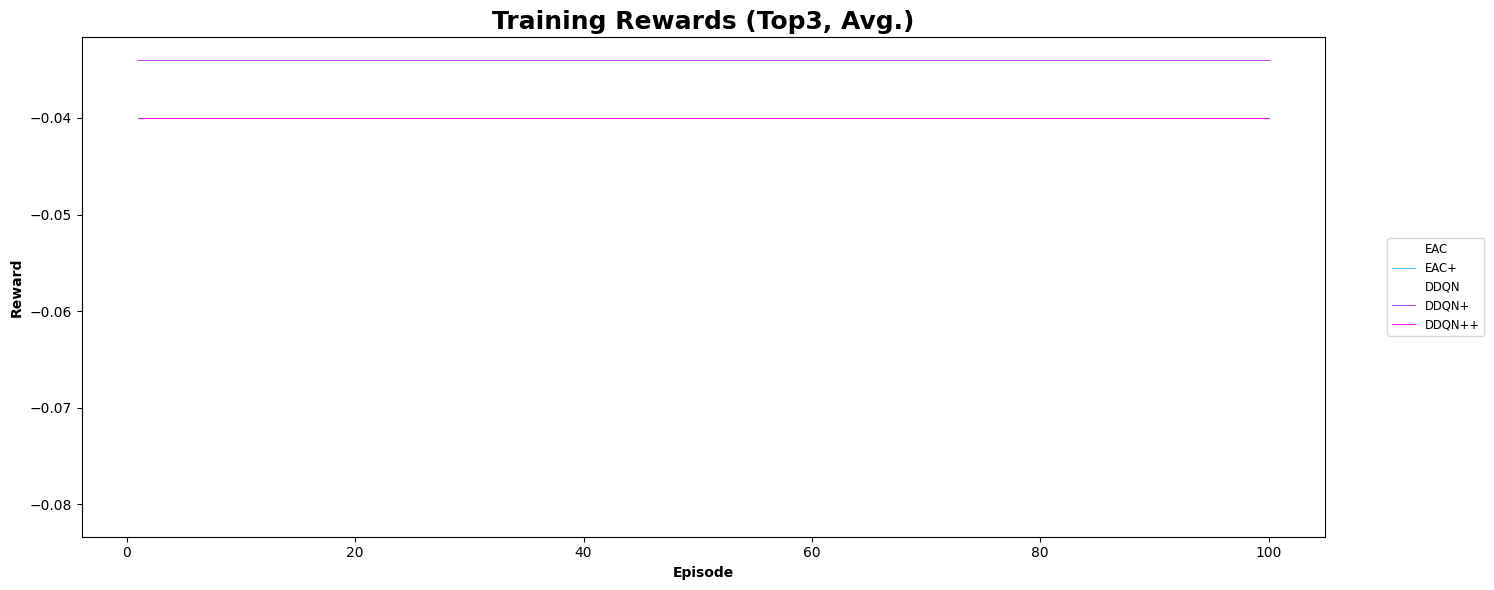

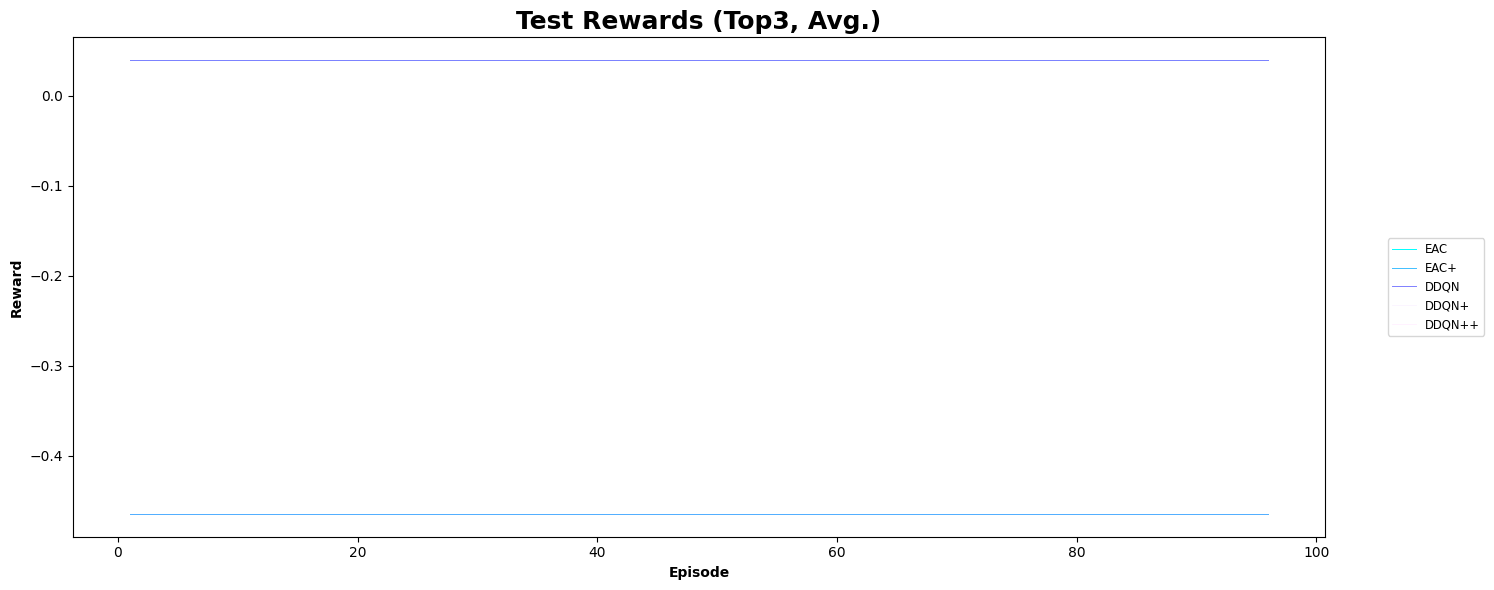

In [62]:
with open("../exp_data/comparison2_tr.pkl", "rb") as f:
   exp_res = pickle.load(f)
with open("../exp_data/comparison2_test.pkl", "rb") as f:
   test_res = pickle.load(f)
plot_rewards_with_opacity(exp_res, "Training Rewards (Top3, Avg.)", "Episode", "Reward","eac_p_tr.png")

# Plot for test_res (test rewards)
plot_rewards_with_opacity(test_res, "Test Rewards (Top3, Avg.)", "Episode", "Reward","eac_p_test.png")